In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import expected_max_performance
import numpy as np

In [69]:
data = {
    "DilatedCNN(CH)": "../stats/seq_ch_conv_3lv.yaml-2020-05-15--13-36.30.csv",
    "DilatedCNN(CH+SY)": "../stats/seq_sy_ch_conv_3lv.yaml-2020-05-15--22-41.30.csv",
#     "UniLSTM(CH)": "../stats/seq_ch_lstm_uni.yaml-2020-05-16--10-14.30.csv",
    "BiLSTM(CH)": "../stats/seq_ch_lstm_bi.yaml-2020-05-22--22-42.30.csv",
    "BiLSTM(CH+SY)": "../stats/seq_sy_ch_lstm_bi.yaml-2020-05-22--22-42.30.csv",
    "BiLSTM(SY)": "../stats/seq_sy_lstm_bi.yaml-2020-05-22--22-42.30.csv",
}


----
seq_ch_conv_3lv size=329152
Val WL-F1=0.9466 ./artifacts/seq_ch_conv_3lv.yaml-2020-05-15--13-36.30/run-23
TEST: CL-f1=0.9684 WL-f1=0.9226
conv:214|do:0.023654636978421406|embc:32|embt:32|l1:36|oc:BI lr=4.87e-05 weight_decay=1.64e-06
avg traiing 64.77714580178261
----
seq_sy_ch_conv_3lv size=574875
Val WL-F1=0.9723 ./artifacts/seq_sy_ch_conv_3lv.yaml-2020-05-15--22-41.30/run-13
TEST: CL-f1=0.9800 WL-f1=0.9501
conv:137|do:0.0929509300900459|embc:32|embs:64|embt:32|l1:42|oc:BI lr=4.65e-04 weight_decay=1.06e-06
avg traiing 62.082446708281836
----
seq_ch_lstm size=1629805
Val WL-F1=0.9430 ./artifacts/seq_ch_lstm_bi.yaml-2020-05-22--22-42.30/run-29
TEST: CL-f1=0.9690 WL-f1=0.9203
bi:1|cells:416|do:0.4279045889213156|embc:32|embt:32|l1:25|oc:BI lr=7.74e-04 weight_decay=6.29e-06
avg traiing 94.21803075353304
----
seq_sy_ch_lstm size=1209891
Val WL-F1=0.9645 ./artifacts/seq_sy_ch_lstm_bi.yaml-2020-05-22--22-42.30/run-19
TEST: CL-f1=0.9754 WL-f1=0.9362
bi:1|cells:257|do:0.0543880159114884|e

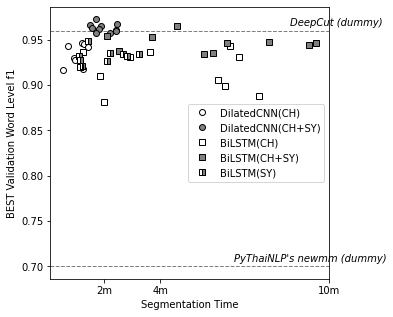

In [78]:

def marker(k):
    if "CNN" in k:
        return "o"
    elif "UniLSTM" in k:
        return "*"
    elif "BiLSTM" in k:
        return "s"
    
def plot_hyperopt(families, n=10):
    plt.figure(figsize=(5, 5))
    # draw max line
    for k in families:
        df = pd.read_csv(data[k]).sort_values(by="best-val:word_level:f1", ascending=False)[:n]
        
        best_model = df[df["best-val:word_level:f1"] == df["best-val:word_level:f1"].max()].to_dict("row")[0]
        print("----")

        print(best_model["name"], "size=%d" % best_model["num_trainable_params"])
        print("Val WL-F1=%.4f" % best_model["best-val:word_level:f1"], best_model["best-val:model_path"])
        print("TEST: CL-f1=%.4f" % best_model["best-test:char_level:f1"], "WL-f1=%.4f" % best_model["best-test:word_level:f1"])
        print(best_model["params"], "lr=%.2e"%best_model["lr"], "weight_decay=%.2e" % best_model["weight_decay"],)
        print("avg traiing", df["training_took"].mean()/60)
        plt.plot(
            df["best-val:time_took"] / 60 , df["best-val:word_level:f1"],
            lw=0,
            label=k,
            marker=marker(k),
            markeredgecolor="black",
            markerfacecolor="gray" if "SY" in k else "white",
            fillstyle="right" if "(SY)" in k else "full",
            markerfacecoloralt="white"
        )

    plt.ylabel("BEST Validation Word Level f1")
    plt.xlabel("Segmentation Time")
    plt.xticks([2, 4, 10], ["2m", "4m", "10m"])
    
    pythai_wlf1 = 0.70
    plt.text(6.6, pythai_wlf1 + 0.005, "PyThaiNLP's newmm (dummy)", style='italic')
    plt.axhline(pythai_wlf1, ls="--", color="gray", lw=1, zorder=0)
    
    
    deepcut_wlf1 = 0.96
    plt.text(8.6, deepcut_wlf1 + 0.005, "DeepCut (dummy)", style='italic')
    plt.axhline(deepcut_wlf1, ls="--", color="gray", lw=1, zorder=0)
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.legend()
    
plot_hyperopt(["DilatedCNN(CH)", "DilatedCNN(CH+SY)", "BiLSTM(CH)", "BiLSTM(CH+SY)", "BiLSTM(SY)"], n=10)

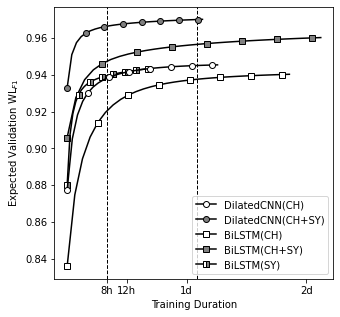

In [71]:
def plot_expected_perf(families):
    plt.figure(figsize=(5, 5))
    plt.axvline(8, ls="--", zorder=0, color="black", lw=1)
    plt.axvline(26, ls="--", zorder=0, color="black", lw=1)
    for k in families:
        df = pd.read_csv(data[k])
        exp_perf = expected_max_performance.samplemax(df["best-val:word_level:f1"])
        mean = np.array(exp_perf["mean"])
        std = np.array(exp_perf["var"])
        _min, _max = exp_perf["min"], exp_perf["max"]
        avg_time = (df["training_took"] / (60*60)).mean()
        x = np.arange(0, df.shape[0]) * avg_time
        plt.plot(
            x, 
            exp_perf["mean"],
            marker=marker(k), 
            label=k,
            markevery=4,
            markerfacecolor="gray" if "SY" in k else "white",
            color="black",
            zorder=1 if "CNN" in k else 0,
            fillstyle="right" if "(SY)" in k else "full",
            markerfacecoloralt="white"
        )
        
#         plt.fill_between(
#             x,
#             np.where(mean - std > _min, mean - std, _min),
#             np.where(mean + std < _max, mean + std, _max),
#             color="gray",
#             alpha=0.2,
#             zorder=0,
#         )
#     plt.ylim(0.8)
    plt.ylabel("Expected Validation WL$_{F1}$")
    plt.xlabel("Training Duration")
    plt.xticks([8, 12, 24, 48], ["8h", "12h", "1d", "2d"])
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.legend()
    
plot_expected_perf(["DilatedCNN(CH)", "DilatedCNN(CH+SY)",  "BiLSTM(CH)", "BiLSTM(CH+SY)", "BiLSTM(SY)"])
plt.savefig("./figures/expected_val_perf.svg")